# Módulo 4: Redes neuronales convolucionales en Pytorch

Es hora de añadir otro conjunto de herramientas importante a nuestros recursos de *deep learning*. Antes, al trabajar con el conjunto de datos MNIST, alisábamos los datos de *input*, y por tanto, perdíamos atributos espaciales fundamentales de las imágenes en 2D. Por eso, vamos a introducir una arquitectura de redes neuronales útil para trabajar con datos espaciales: las capas convolucionales o CNN.

Como hemos visto en el módulo, las capas convolucionales no requieren que modifiquemos las dimensiones originales de los datos durante el entrenamiento. En este cuaderno, repetiremos las tareas de autocodificación y clasificación del conjunto de datos MNIST, pero, esta vez, utilizaremos las capas CNN.

Este tipo de capas son muy fáciles de incluir en PyTorch y mejoran el rendimiento de los modelos.

## Autocodificador CNN con cifras MNIST

En primer lugar, repetiremos la implementación de autocodificadores. Aunque con las capas de 1D conseguimos un rendimiento aceptable, incluir convoluciones mejorará la autocodificación.

### Preparación del conjunto de datos e importación del módulo

Aunque cambiemos la arquitectura de la red neuronal, la preparación del conjunto de datos y la importación del módulo funcionarán exactamente de la misma forma.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [2]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# Dividiremos el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [3]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Definición e hiperparámetros del modelo

Los principales cambios se producirán en la definición del modelo. Concretamente, vemos que se han introducido varias capas nuevas:

*   `nn.Conv2d` Esta es la convolución principal
*   `nn.MaxPool2d` Es la capa de *max pooling* que submuestrea la imagen
*   `nn.Flatten` Alisa la imagen y la reduce a una sola dimensión
*   `nn.UnFlatten` Le devuelve a la imagen la forma y el número de dimensiones deseadas
*   `nn.ConvTranspose2d` "Desconvoluciona" las imágenes

Como puede observar, aunque se hayan introducido nuevas capas, seguimos el mismo patrón de codificación-decodificación.


In [13]:
from torch.nn.modules.flatten import Flatten
class CNNAutoEncoder(nn.Module):
    # Muchos de estos números (en especial la capa lineal del final del codificador
    # y el principio del decodificador) están codificados para el tamaño de imagen 28 x 28 
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        # Dividir el codificador y el decodificador

        self.encoder = nn.Sequential(
            # Realizamos una convolución del input
            # in_channels = 1 porque el input es una imagen en escala de grises
            # El tamaño de la capa Conv2d da lugar a que el tamaño del output se modifique
            # a (8, 28, 28). 
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            # Implementar ReLU() igual que en una capa lineal
            nn.ReLU(),
            # MaxPool2d reducirá la imagen a (8, 14, 14)
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # Alisar la capa
            nn.Flatten(),
            # Implementar ReLU para la no linealidad
            nn.ReLU(),
            # Una última capa lineal para la codificación de tamaño 32 (como en la versión anterior)
            nn.Linear(8*14*14, 32),
        )

        self.decoder = nn.Sequential(
            # El input del decodificador será un tensor lineal de longitud 64
            nn.Linear(32, 8*14*14),
            # Implementar ReLU para la no linealidad
            nn.ReLU(),
            # Aquí, volveremos al tamaño no alisado
            nn.Unflatten(dim = 1, unflattened_size = (8, 14, 14)),
            # Implementar ReLU para la no linealidad
            nn.ReLU(),
            # "ConvTranspose2d" se puede entender como una "desconvolución". Nos devuelve a las dimensiones originales (1, 28, 28)

            nn.ConvTranspose2d(in_channels = 8, out_channels = 1, kernel_size = 2, stride = 2),
        )
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)

In [14]:
learning_rate = 0.001
num_epochs = 10

model = CNNAutoEncoder().to(device)
print(model)

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): ReLU()
    (5): Linear(in_features=1568, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(8, 14, 14))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


### Entrenamiento del modelo

Aunque este modelo es mucho más complejo, podemos utilizar la función de entrenamiento autocodificadora simple. Sin embargo, esta vez no alisaremos los *inputs*, porque ahora podemos tratar imágenes 2D como *input*.

In [15]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación
            running_loss = 0.0

            # Iterar con los datos - para el autocodificador no nos importan las etiquetas,
            # estamos entrenando al input contra sí mismo
            for inputs, _ in dataloaders[phase]:
                # Ya no hay que alisar los inputs
                inputs = inputs.to(device)
                # Los objetivos son iguales que los inputs
                targets = inputs.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [16]:
# Pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.2900
val   Loss: 0.1447
test  Loss: 0.1436

Epoch 2/10
----------
train Loss: 0.1167
val   Loss: 0.0960
test  Loss: 0.0945

Epoch 3/10
----------
train Loss: 0.0874
val   Loss: 0.0797
test  Loss: 0.0782

Epoch 4/10
----------
train Loss: 0.0759
val   Loss: 0.0720
test  Loss: 0.0705

Epoch 5/10
----------
train Loss: 0.0698
val   Loss: 0.0672
test  Loss: 0.0657

Epoch 6/10
----------
train Loss: 0.0660
val   Loss: 0.0645
test  Loss: 0.0631

Epoch 7/10
----------
train Loss: 0.0637
val   Loss: 0.0624
test  Loss: 0.0611

Epoch 8/10
----------
train Loss: 0.0615
val   Loss: 0.0604
test  Loss: 0.0590

Epoch 9/10
----------
train Loss: 0.0600
val   Loss: 0.0591
test  Loss: 0.0578

Epoch 10/10
----------
train Loss: 0.0589
val   Loss: 0.0581
test  Loss: 0.0568

Training complete in 3m 45s
Best val Loss: 0.058077 at epoch 9


Recordemos que el autocodificador totalmente lineal con la codificación del espacio latente a un tamaño de 32 logró una pérdida ligeramente similar. Sin embargo, al visualizar los puntos de datos de abajo, vemos que el modelo de CNN es capaz de reconstruir con mayor precisión las imágenes de *input*.

### Visualización de los resultados

Vamos a probar a visualizar algunas de las imágenes. Observará que la reconstrucción es más precisa que en el autocodificador anterior, en especial, para las cifras 8 y 9.

In [17]:
# Trazar una ground truth sobre las cifras y autocodificar
def plot_digit(digit, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        for i, input in enumerate(inputs):
            # Solo queremos mostrar determinadas cifras
            if (labels[i] != digit):
                continue
            # Ejecutar el autocodificador
            autoencoding = model.forward(input.reshape(1,1,28,28)) # Debemos remodelar la forma para tener en cuenta el tamaño de lotes de 1 en la evaluación
            # Volver a la cpu()
            autoencoding = autoencoding.cpu().detach().numpy()
            # Remodelar en forma de imagen
            autoencoding = autoencoding.reshape((28,28))
            input = input.cpu().detach().numpy().reshape((28,28))
            # Trazar la ground truth
            ax = fig.add_subplot(2, count, idx)
            ax.imshow(input, cmap='gray')
            # Trazar la autocodificación
            ax = fig.add_subplot(2, count, idx+count)
            ax.imshow(autoencoding, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

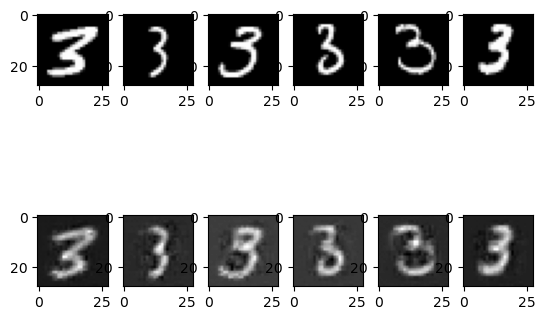

In [19]:
plot_digit(3,6)

## CNN profunda para la clasificación del conjunto de datos MNIST

Ahora que tenemos potentes capas convolucionales, volvamos a la tarea de clasificación del conjunto de cifras MNIST.

Antes, logramos una eficacia de en torno al 96 % con un clasificador de una sola dimensión. Ahora, vamos a introducir las capas convolucionales y a comprobar el rendimiento del modelo.



### Preparación del conjunto de datos e importación del módulo

In [21]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [22]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# Dividiremos el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [23]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Definición e hiperparámetros del modelo

Para el modelo CNN, primero realizaremos una convolución y una operación de *max pooling* para que aprenda atributos 2D del conjunto de datos. Después, realizaremos un alisado e incluiremos dos capas para reducir la clasificación a las 10 categorías que nos interesan. 

La mayoría de CNN siguen este patrón: se realiza una extracción de atributos espaciales al principio de la red y se incluyen capas lineales para la clasificación al final.

In [24]:
from torch.nn.modules.flatten import Flatten
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Dividir el codificador y el decodificador

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.pipeline(x)


In [25]:
learning_rate = 0.001
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Entrenamiento del modelo



In [26]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

     # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # No hace falta alisar los inputs
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [27]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También guardaremos los resultados del entrenamiento para poder visualizarlos
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.4762 Acc: 0.8674
val   Loss: 0.2094 Acc: 0.9387
test  Loss: 0.1982 Acc: 0.9441

Epoch 2/10
----------
train Loss: 0.1596 Acc: 0.9545
val   Loss: 0.1309 Acc: 0.9626
test  Loss: 0.1204 Acc: 0.9663

Epoch 3/10
----------
train Loss: 0.1125 Acc: 0.9670
val   Loss: 0.1072 Acc: 0.9691
test  Loss: 0.0957 Acc: 0.9719

Epoch 4/10
----------
train Loss: 0.0900 Acc: 0.9740
val   Loss: 0.0984 Acc: 0.9699
test  Loss: 0.0850 Acc: 0.9741

Epoch 5/10
----------
train Loss: 0.0757 Acc: 0.9781
val   Loss: 0.0905 Acc: 0.9717
test  Loss: 0.0769 Acc: 0.9758

Epoch 6/10
----------
train Loss: 0.0653 Acc: 0.9807
val   Loss: 0.0848 Acc: 0.9737
test  Loss: 0.0719 Acc: 0.9773

Epoch 7/10
----------
train Loss: 0.0570 Acc: 0.9832
val   Loss: 0.0805 Acc: 0.9753
test  Loss: 0.0686 Acc: 0.9783

Epoch 8/10
----------
train Loss: 0.0503 Acc: 0.9854
val   Loss: 0.0782 Acc: 0.9758
test  Loss: 0.0672 Acc: 0.9780

Epoch 9/10
----------
train Loss: 0.0449 Acc: 0.9871
val   Loss: 0.0768

Cuando el modelo haya terminado de entrenar, veremos que, con solo incluir un conjunto de capas convolucionales, hemos mejorado el rendimiento comparado con el anterior MLP de 1D. Es una gran mejora para una implementación de CNN tan sencilla. Si añadiésemos más capas y técnicas convolucionales, aumentaría la mejora.

### Visualización de las curvas de entrenamiento y los resultados

 Al incluir funciones para examinar las curvas de entrenamiento y la matriz de confusión veremos que la matriz contiene menos puntos de datos clasificados incorrectamente que antes.

In [28]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


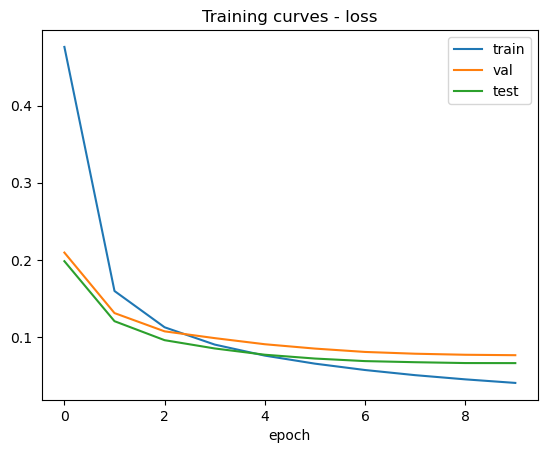

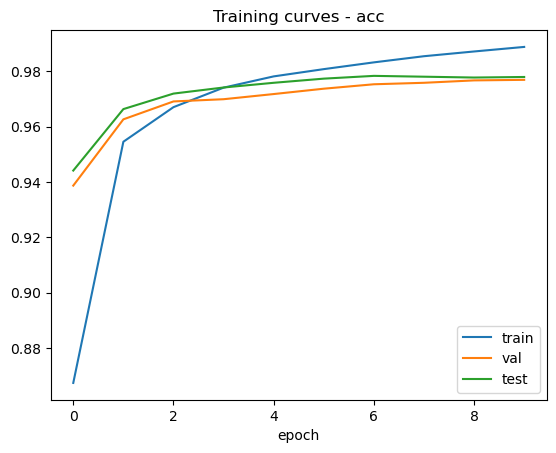

In [29]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

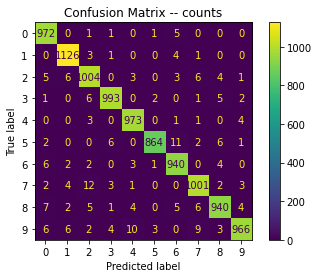

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')

## ¿Qué viene después?

Ahora que hemos introducido las convoluciones en 2D, podremos construir redes neuronales mucho más complejas. En la actividad evaluable, deberá construir y diseñar, a partir de la capa convolucional que hemos creado, un modelo con al menos 2 capas convolucionales para clasificar un nuevo conjunto de datos.